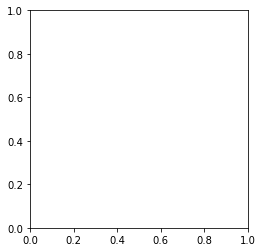

In [1]:
#%matplotlib widget
import matplotlib.pyplot as plt
plt.gca().set_aspect('equal')


import numpy as np
import cv2
import glob
import json
import pickle

from dataclasses import dataclass

from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)


import plotly.graph_objects as go

def plot(
    points, connection_idx_list,
    line_color_list = None,
    show = True
) :
    '''
    points : np.ndarray
        shape : N, 2
    '''
    if not line_color_list :
        line_color_list = ['red'] * (len(connection_idx_list))

    fig = go.Figure(
        data = list(map(
            lambda i, j, c : go.Scatter(
                x = points[[i, j], 0],
                y = points[[i, j], 1],
                mode = 'lines+markers+text',
                line = dict(
                    color = c
                ),
                marker = dict(
                    color = c,
                    size = 2
                )
            ),
            connection_idx_list[:-1],
            connection_idx_list[1:],
            line_color_list
        ))
    )
    fig.update_yaxes(scaleanchor='x', scaleratio=1)

    if show :
        fig.show()

def plot3d(
    points, connection_idx_list,
    line_color_list = None,
    show = True
) :
    '''
    points : np.ndarray
        shape : N, 3
    '''
    if not line_color_list :
        line_color_list = ['red'] * (len(connection_idx_list))

    fig = go.Figure(
        data = list(map(
            lambda i, j, c : go.Scatter3d(x = points[[i, j], 0],
                y = points[[i, j], 1],
                z = points[[i, j], 2],
                mode = 'lines+markers+text',
                line = dict(
                    color = c
                ),
                marker = dict(
                    color = c,
                    size = 2
                )
            ),
            connection_idx_list[:-1],
            connection_idx_list[1:],
            line_color_list
        ))
    )

    max_range = np.max(np.ptp(points, axis=0))
    xmin, ymin, zmin = points.min(axis=0)

    fig.update_layout(scene=dict(aspectmode='cube'))
    fig.update_layout(scene=dict(
        xaxis = dict(range=[xmin-0.1, xmin + max_range+ 0.1]),
        yaxis = dict(range=[ymin-0.1, ymin + max_range+ 0.1]),
        zaxis = dict(range=[zmin-0.1, zmin + max_range+ 0.1])
    ))

    layout = go.Layout(
        scene = dict(
            camera = dict(
                eye = dict(x=-1, y = -1, z = 1)
            )
        )
    )
    fig.layout = layout
    if show :
        fig.show()

@dataclass
class OpenPoseLandmark :
    nose       : np.ndarray = None  # 0
    neck       : np.ndarray = None  # 1
    shoulder_r : np.ndarray = None  # 2
    elbow_r    : np.ndarray = None  # 3
    wrist_r    : np.ndarray = None  # 4
    shoulder_l : np.ndarray = None  # 5
    elbow_l    : np.ndarray = None  # 6
    wrist_l    : np.ndarray = None  # 7
    hip_r      : np.ndarray = None  # 8
    knee_r     : np.ndarray = None  # 9
    anklle_r   : np.ndarray = None  # 10
    hip_l      : np.ndarray = None  # 11
    knee_l     : np.ndarray = None  # 12
    ankle_l    : np.ndarray = None  # 13
    eye_r      : np.ndarray = None  # 14
    eye_l      : np.ndarray = None  # 15
    ear_r      : np.ndarray = None  # 16
    ear_l      : np.ndarray = None  # 17
    
    CONN_PATH_LIST = [16, 14, 0, 15, 17, 15, 0, 1, 2, 3, 4, 3, 2, 1, 5, 6, 7, 6, 5, 1, 8, 9, 10, 9, 8, 1, 11, 12, 13]

    @staticmethod
    def azurkinect2openpose(landmark) :
        nose       = landmark[27]
        neck       = landmark[3]
        shoulder_r = landmark[12]
        elbow_r    = landmark[13]
        wrist_r    = landmark[14]
        shoulder_l = landmark[5]
        elbow_l    = landmark[6]
        wrist_l    = landmark[7]
        hip_r      = landmark[22]
        knee_r     = landmark[23]
        anklle_r   = landmark[24]
        hip_l      = landmark[18]
        knee_l     = landmark[19]
        ankle_l    = landmark[20]
        eye_r      = landmark[30]
        eye_l      = landmark[29]
        ear_r      = landmark[31]
        ear_l      = landmark[29]
        
        return np.vstack([
            nose, neck,
            shoulder_r, elbow_r, wrist_r,
            shoulder_l, elbow_l, wrist_l,
            hip_r, knee_r, anklle_r,
            hip_l, knee_l, ankle_l,
            eye_r,
            eye_l,
            ear_r,
            ear_l,
        ])

    @staticmethod
    def mediapipe2openpose(landmark) :
        nose = landmark[0]
        neck = (landmark[11] + landmark[12]) / 2
        shoulder_r = landmark[12]
        elbow_r = landmark[14]
        wrist_r = landmark[16]
        shoulder_l = landmark[11]
        elbow_l = landmark[13]
        wrist_l = landmark[15]
        hip_r = landmark[24]
        knee_r = landmark[26]
        anklle_r = landmark[28]
        hip_l = landmark[23]
        knee_l = landmark[25]
        ankle_l = landmark[27]
        eye_r = landmark[5]
        eye_l = landmark[2]
        ear_r = landmark[8]
        ear_l = landmark[7]

        return np.vstack([
            nose, neck,
            shoulder_r, elbow_r, wrist_r,
            shoulder_l, elbow_l, wrist_l,
            hip_r, knee_r, anklle_r,
            hip_l, knee_l, ankle_l,
            eye_r,
            eye_l,
            ear_r,
            ear_l,
        ])

@dataclass
class SimplePose :
    landmarks = np.array([
        [0, 0, 0],
        [0, 0, 1],
        [0, 1, 1],
        [0, 1, 0],
        [1, 0, 0],
        [1, 0, 1],
        [1, 1, 1],
        [1, 1, 0],
    ]) - 0.5
    CONN_PATH_LIST = [0, 1, 2, 3, 0, 4, 5, 1, 5, 6, 2, 6, 7, 3, 7, 4]

class PoseVisualizer :
    POSE_FORMAT = {
        0 : "nose",
        1 : "left_eye"
    }

    # left right flag    
    LR_FLAG = [0, -1, -1, -1, 1, 1, 1, 0, 0, 0, 0, -1, -1, -1, 1, 1, 1]
    LR_MAP = {"middle":0, "left":-1, "right":1}
    
    CONN_LIST = [
        18, 16, 14, 12, 11, 13, 15, 17,
        15, 13, 11, 23, 25, 27, 29, 
        27, 25, 23, 24, 26, 28, 30, 28, 26, 24, 12
    ]

    @classmethod
    def visualize(cls, pose_data, conn_list = None) :

        if not conn_list :
            conn_list = cls.CONN_LIST

        plt.figure(figsize=(8, 8))
        ax = plt.axes(projection='3d')
        
        x_list = np.array(pose_data.T[0][conn_list])
        y_list = np.array(pose_data.T[1][conn_list])
        z_list = np.array(pose_data.T[2][conn_list])

        #set_axes_equal(ax)
        ax.plot(x_list, y_list, z_list)
        
        for idx, coord in enumerate(pose_data) :
            ax.text( *coord, str(idx)  )
        plt.show()

    @classmethod
    def visualize2D(cls, pose_data, conn_list = None) :

        print(pose_data[:, 0], pose_data[:, 1])

        plt.plot(pose_data[:, 0] , pose_data[:, 1])
        plt.show()

        return
        if not conn_list :
            conn_list = cls.CONN_LIST

        plt.figure(figsize=(8, 8))
        ax = plt.axes(projection='3d')
        
        x_list = np.array(pose_data.T[0][conn_list])
        y_list = np.array(pose_data.T[1][conn_list])
        ax.plot(x_list, y_list)
        
        #for idx, coord in enumerate(pose_data) :
        #    ax.text( *(coord[:2]), str(idx)  )
        plt.show()



def rpy2rm(roll, pitch, yaw) :
    c = np.cos
    s = np.sin
    r, p, y = roll, pitch, yaw
    Rz = np.array([
        [ c(y), -s(y), 0],
        [ s(y),  c(y), 0],
        [    0,     0, 1]
    ])
    Ry = np.array([
        [ c(p), 0, -s(p)],
        [    0, 1,     0],
        [ s(p), 0,   c(p)]
    ])
    Rx = np.array([
        [1, 0, 0],
        [0, c(r), -s(r)],
        [0, s(r),  c(r)]
    ])
    return Rz @ Ry @ Rx

def project2image(coord, extrinsic, intrinsic) :
    '''
    coord : np.ndarray
        shape : N, 3
    '''
    coord_in = np.hstack([coord, np.ones((coord.shape[0], 1))])
    transformed = np.matmul(extrinsic, coord_in.T).T
    transformed /= transformed[:, -1].reshape(-1, 1)

    projected = np.matmul(intrinsic, transformed[:, :3].T).T
    return projected / projected[:, -1].reshape(-1, 1)


def project(coord, intrinsic) :
    projected = np.matmul(intrinsic, coord[:, :3].T).T
    return projected / projected[:, -1].reshape(-1, 1)

IMG_WIDTH = 1920
IMG_HWIGHT = 1440

IMG_WIDTH = 100
IMG_HWIGHT = 100                                                                                                        

DATA_SOURCE = "mediapipe"
DATA_SOURCE = "azure_kinect"

if DATA_SOURCE == "azure_kinect" :

    DATA_DIR_PATH = "../azure_kinect_data" 
    POSE_DATA_SHAPE = (-1, 32, 8)
    DATA_PATH_LIST = sorted(glob.glob(f"{DATA_DIR_PATH}/*/*.pkl"))

    pose_data_list = []

    for idx, data_path in enumerate(DATA_PATH_LIST) :
        with open(data_path, "rb") as fp :
            landmark = np.array(
                pickle.load(fp)
            )
            landmark = landmark[:, :3]
        pose_data_list.append(landmark)
    pose_data_list = np.array(pose_data_list)
    
    openpose_data_list = np.array(list(map(
        lambda pose : OpenPoseLandmark.azurkinect2openpose(pose), # / pose.mean(axis = 0)),
        pose_data_list
    )))

elif DATA_SOURCE == "mediapipe" :
    DATA_DIR_PATH = "../data" 
    POSE_DATA_SHAPE = (-1, 3, 33)
    DATA_PATH_LIST = sorted(glob.glob(f"{DATA_DIR_PATH}/*/*.json"))
    IMG_PATH_LIST = sorted(glob.glob(f"{DATA_DIR_PATH}/*/*.png"))

    pose_data_list = []

    for idx, data_path in enumerate(DATA_PATH_LIST) :
        with open(data_path, "r") as fp :
            landmark = np.array(
                json.load(fp)["landmarks"]
            ) * np.array([IMG_WIDTH, IMG_HWIGHT, IMG_WIDTH]).reshape(1, -1)
            
        pose_data_list.append(landmark)
    pose_data_list = np.array(pose_data_list)

    openpose_data_list = np.array(list(map(
        lambda pose : OpenPoseLandmark.azurkinect2openpose(pose / pose.mean(axis = 0)),
        pose_data_list
    )))

In [2]:
roll  = np.deg2rad(0)
pitch = np.deg2rad(0)
yaw   = np.deg2rad(0)
distance = 2000

R = np.matmul(
    rpy2rm(np.deg2rad(-90), np.deg2rad(-90), 0),
    rpy2rm(roll, pitch, yaw)
)

translation = np.matmul(
    R,
    np.array([0, 0, distance]).reshape(-1, 1)
).reshape(-1, 1)

extrinsic = np.vstack([
    np.hstack([
        np.linalg.inv(R) ,
        np.array([0, 0, distance]).reshape(-1, 1)
    ]),
    np.array([0, 0, 0, 1])
])

f = 2
cx = 10
cy = 10
intrinsic = np.array([
    [f, 0, cx],
    [0, f, cy],
    [0, 0, 1]
])

base_R = rpy2rm(np.deg2rad(-90), 0, 0)
IDX = -2
landmark = openpose_data_list[IDX]
landmark = np.matmul(base_R,landmark.T).T

projected = project2image(landmark, extrinsic, intrinsic)
'''
plot3d(
    np.matmul(base_R, pose_data_list[IDX].T).T,
    [
        25, 24, 23, 22, 0, 18, 19, 20, 21, 20, 19, 18, 0,
        1, 2, 11, 12, 13, 14, 15, 14, 13, 12, 11, 2, 
        4, 5, 6 ,7 , 8, 7, 6, 5, 4, 2, 3, 26,
        27, 30, 31, 30, 27, 28, 29
    ]
)
'''

plot3d(landmark, OpenPoseLandmark.CONN_PATH_LIST)

plot(projected, OpenPoseLandmark.CONN_PATH_LIST)

In [65]:
pose_data_list.shape

(465, 32, 3)

In [119]:
roll  = np.deg2rad(0)  # pitch
pitch = np.deg2rad(0)  # yaw
yaw   = np.deg2rad(45) # roll
distance = 2

R = np.matmul(
    rpy2rm(np.deg2rad(-90), np.deg2rad(-90), 0),
    rpy2rm(roll, pitch, yaw)
)

print("R")
print(R)

translation = np.matmul(
    R,
    np.array([0, 0, distance]).reshape(-1, 1)
).reshape(-1, 1)

extrinsic = np.vstack([
    np.hstack([
        
        np.linalg.inv(R) ,
        #np.linalg.inv(np.matmul(
        #    rpy2rm( np.deg2rad(00), np.deg2rad(90), np.deg2rad(00) ), R
        #)),

        np.array([0, 0, distance]).reshape(-1, 1)

        #translation
    ]),
    np.array([0, 0, 0, 1])
])

print('extrinsic')
print(extrinsic)

f = 2
cx = 10
cy = 10
intrinsic = np.array([
    [f, 0, cx],
    [0, f, cy],
    [0, 0, 1]
])

projected = project2image(SimplePose.landmarks, extrinsic, intrinsic)

plot3d(SimplePose.landmarks, SimplePose.CONN_PATH_LIST)
plot(projected, SimplePose.CONN_PATH_LIST)
#PoseVisualizer.visualize(projected, SimplePose.CONN_PATH_LIST)

R
[[-7.07106781e-01 -7.07106781e-01  6.12323400e-17]
 [ 4.32978028e-17  4.32978028e-17  1.00000000e+00]
 [-7.07106781e-01  7.07106781e-01  3.74939946e-33]]
extrinsic
[[-7.07106781e-01  4.32978028e-17 -7.07106781e-01  0.00000000e+00]
 [-7.07106781e-01  4.32978028e-17  7.07106781e-01  0.00000000e+00]
 [ 6.12323400e-17  1.00000000e+00  1.27035909e-33  2.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [2]:
pitch_min = -40
pitch_max = 20
yaw_min = 0
yaw_max = 360
distance_min = 2000
distance_max = 3000

pitch = np.deg2rad(np.random.uniform(pitch_min, pitch_max))
yaw   = np.deg2rad(np.random.uniform(yaw_min, yaw_max))
distance = np.random.uniform(distance_min, distance_max)

R = rpy2rm(0, pitch, yaw)

translation = np.matmul(
    R,
    np.array([distance, 0, 0]).reshape(-1, 1)
).reshape(-1, 1)

extrinsic = np.vstack([
    np.hstack([R, translation]),
    np.array([0, 0, 0, 1])
])

In [98]:
roll = 90
pitch = 90
yaw = 0
R = rpy2rm(np.deg2rad(roll), np.deg2rad(pitch), np.deg2rad(yaw))

IDX = 0
open_pose_landmark = OpenPoseLandmark.mediapipe2openpose(pose_data_list[IDX])
open_pose_landmark -= open_pose_landmark.mean(axis=0)

open_pose_landmark_rotated = np.matmul(
    R, open_pose_landmark.T
).T

plot3d(open_pose_landmark, OpenPoseLandmark.CONN_PATH_LIST)
plot3d(open_pose_landmark_rotated, OpenPoseLandmark.CONN_PATH_LIST)

In [85]:
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

import plotly.express as px
import plotly.graph_objects as go
import numpy as np

roll = 45
pitch = 45
yaw = 0

R = rpy2rm(np.deg2rad(roll), np.deg2rad(pitch), np.deg2rad(yaw))

points = np.array([
    [0, 0, 0],
    [0, 0, 1],
    [0, 1, 0],
    [1, 0, 0]
])
conn_map = [0, 1, 0, 2, 0, 3, 0]

def plot3d(points, conn_map) :
    fig = go.Figure(
        data = [go.Scatter3d(
            x = points[conn_map][:, 0],
            y = points[conn_map][:, 1],
            z = points[conn_map][:, 2]
        )]
    )
    fig.update_layout(scene=dict(aspectmode='cube'))

    max_range = np.max(np.ptp(points, axis=0))
    xmin, ymin, zmin = points.min(axis=0)

    print(xmin, ymin, zmin)

    fig.update_layout(scene=dict(
        xaxis = dict(range=[xmin-0.1, xmin + max_range+ 0.1]),
        yaxis = dict(range=[ymin-0.1, ymin + max_range+ 0.1]),
        zaxis = dict(range=[zmin-0.1, zmin + max_range+ 0.1])
    ))

    layout = go.Layout(
        scene = dict(
            camera = dict(
                eye = dict(x=-1, y = -1, z = 1)
            )
        )
    )
    fig.layout = layout
    fig.show()

rotated = np.matmul(R, points.T).T

print("rotated")
print(rotated)

plot3d(points, conn_map)
plot3d(rotated, conn_map)

rotated
[[ 0.          0.          0.        ]
 [-0.5        -0.70710678  0.5       ]
 [-0.5         0.70710678  0.5       ]
 [ 0.70710678  0.          0.70710678]]
0 0 0


-0.5 -0.7071067811865475 0.0


In [32]:
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

import plotly.express as px
import plotly.graph_objects as go
import numpy as np

roll = 45
pitch = 0
yaw = 0

R = rpy2rm(np.deg2rad(roll), np.deg2rad(pitch), np.deg2rad(yaw))

def plot3d(points, conn_map) :
    fig = go.Figure(
        data = [go.Scatter3d(
            x = points[conn_map][:, 0],
            y = points[conn_map][:, 1],
            z = points[conn_map][:, 2]
        )]
    )
    fig.update_layout(scene=dict(aspectmode='cube'))

    max_range = np.max(np.ptp(points, axis=0))
    xmin, ymin, zmin = points.min(axis=0)

    print(xmin, ymin, zmin)

    fig.update_layout(scene=dict(
        xaxis = dict(range=[xmin-0.1, xmin + max_range+ 0.1]),
        yaxis = dict(range=[ymin-0.1, ymin + max_range+ 0.1]),
        zaxis = dict(range=[zmin-0.1, zmin + max_range+ 0.1])
    ))

    layout = go.Layout(
        scene = dict(
            camera = dict(
                eye = dict(x=-1, y = -1, z = 1)
            )
        )
    )
    fig.layout = layout
    fig.show()

rotated = np.matmul(R, points.T).T

print("rotated")
print(rotated)

plot3d(points, conn_map)
plot3d(rotated, conn_map)


TypeError: dict expected at most 1 argument, got 2